In [72]:
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 
from keras.applications.vgg16 import VGG16 
from sklearn.metrics import silhouette_score
from keras.models import Model
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import os
import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
matplotlib.rcParams['font.family'] = 'Times New Roman'

In [73]:
path = r"../images"
os.chdir(path)

In [74]:
plantas = []

In [75]:
with os.scandir(path) as files:
    for file in files:
        if file.name.endswith('.png'):
            plantas.append(file.name)

# Clustering usando features

In [76]:
df = pd.read_csv('../imageFeatures.csv')


pipeline_df = df.copy()
pipeline_df.drop(['image_name', 'coincidencia', 'relevant (new) tags', 'trial_id', 'layout_id'], axis=1, inplace=True)

# df.drop(['image_name', 'coincidencia', 'relevant (new) tags', 'trial_id', 'layout_id'], axis=1, inplace=True)

label_encoder = LabelEncoder()
pipeline_df['country'] = label_encoder.fit_transform(df['country'])

numeric_features = pipeline_df.columns.tolist()
numeric_features.remove('country')

numeric_transformer = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

In [77]:
pipeline = make_pipeline(preprocessor, KMeans(n_clusters=3, random_state=42))

# Fit the pipeline
pipeline.fit(pipeline_df)

cluster_labels = pipeline.predict(pipeline_df)

silhouette_avg = silhouette_score(pipeline_df, cluster_labels)
print("Silhouette Score:", silhouette_avg)

/Users/azulmakk/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: -0.07762870903017147


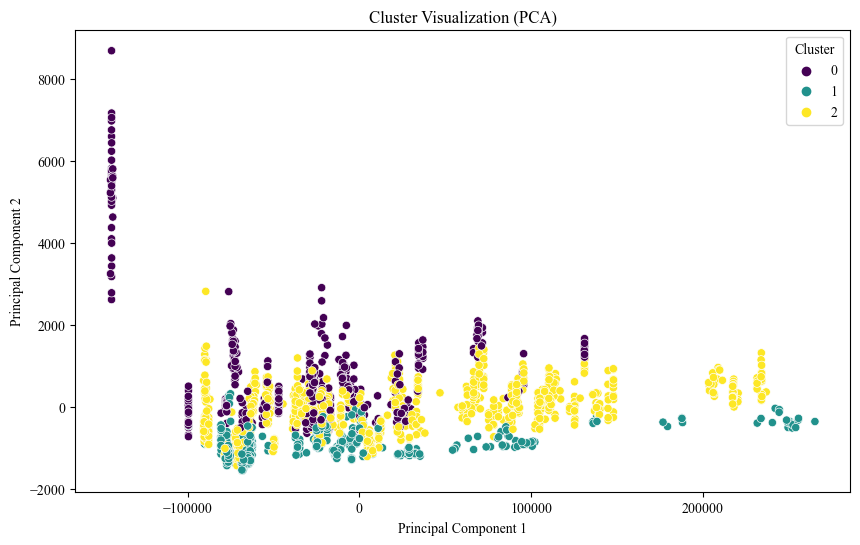

In [78]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(pipeline_df)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=cluster_labels, palette='viridis')
plt.title('Cluster Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

/Users/azulmakk/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/azulmakk/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/azulmakk/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/azulmakk/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

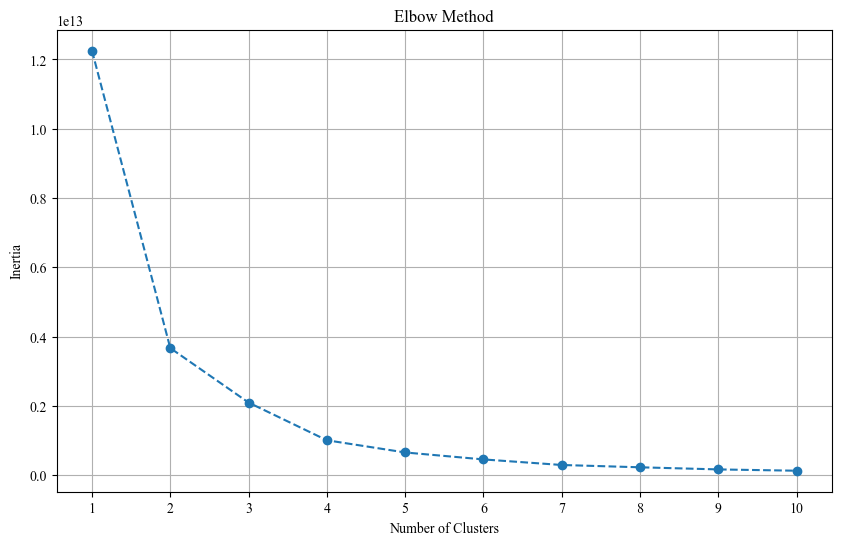

In [79]:
imputer = SimpleImputer(strategy='mean')
df_imputed = imputer.fit_transform(pipeline_df)

inertia_values = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_imputed)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia_values, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

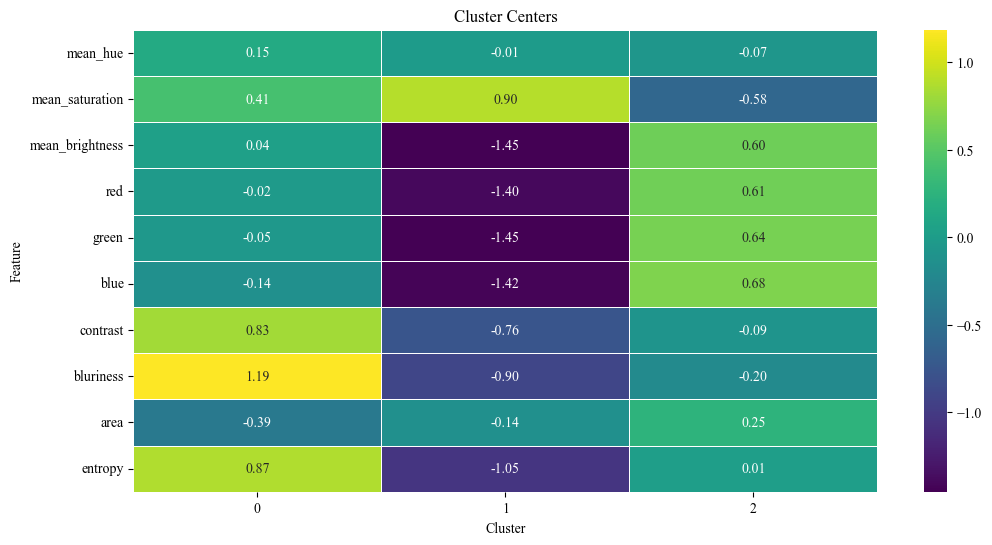

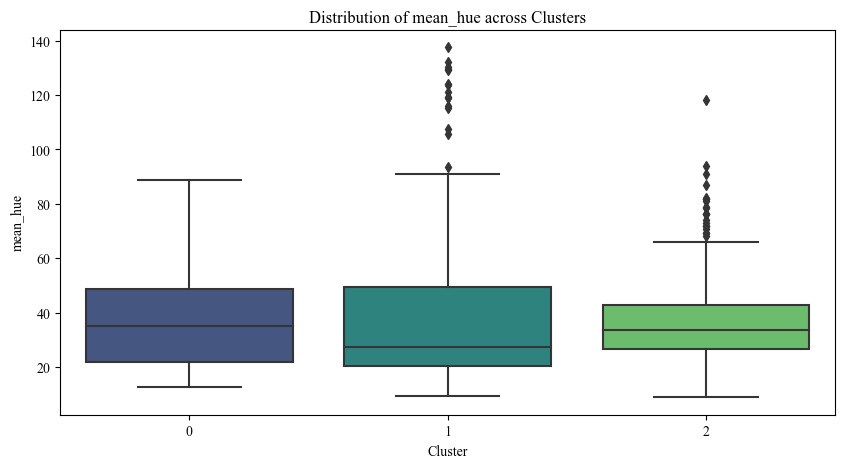

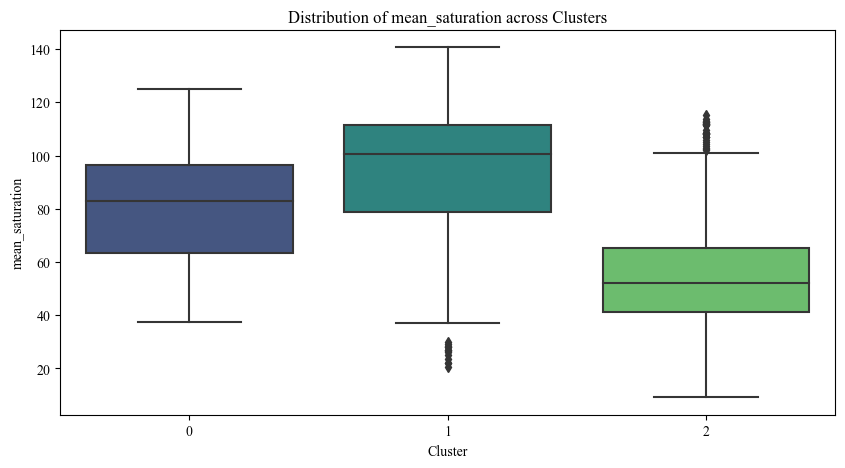

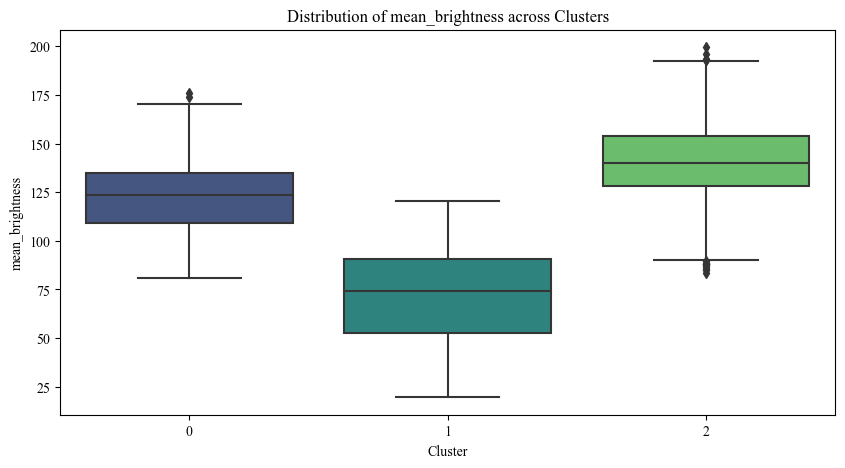

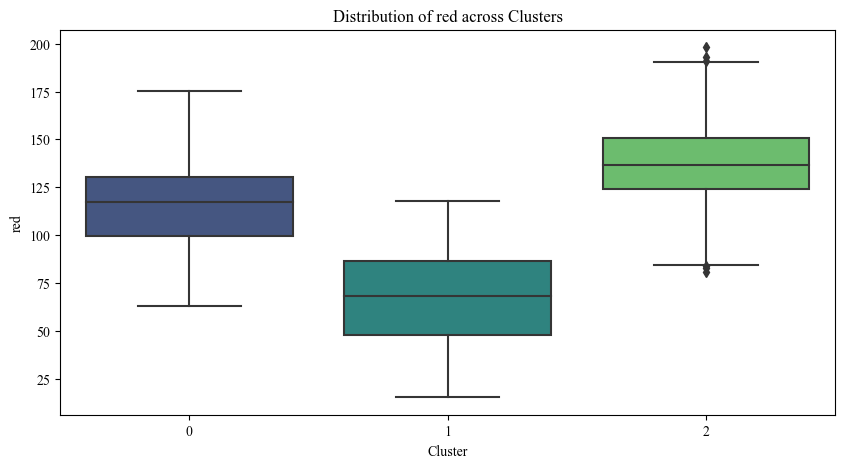

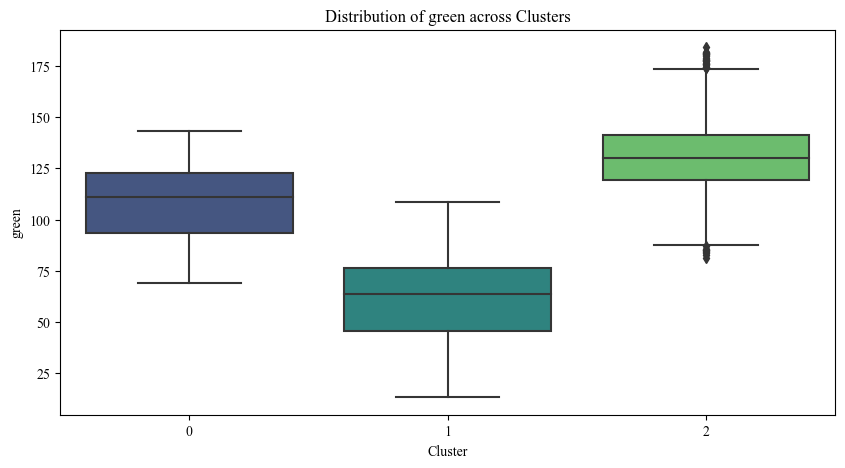

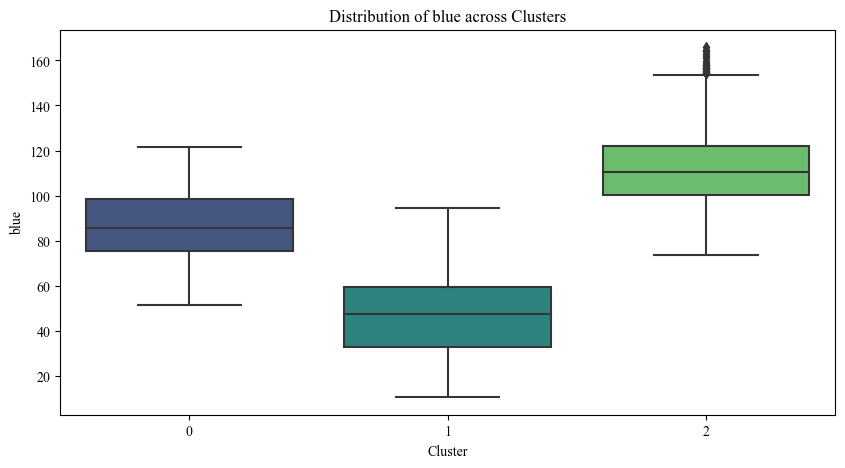

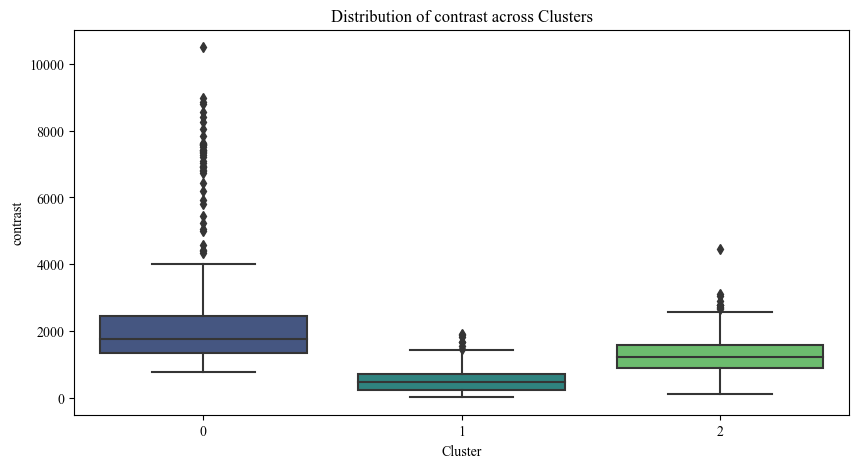

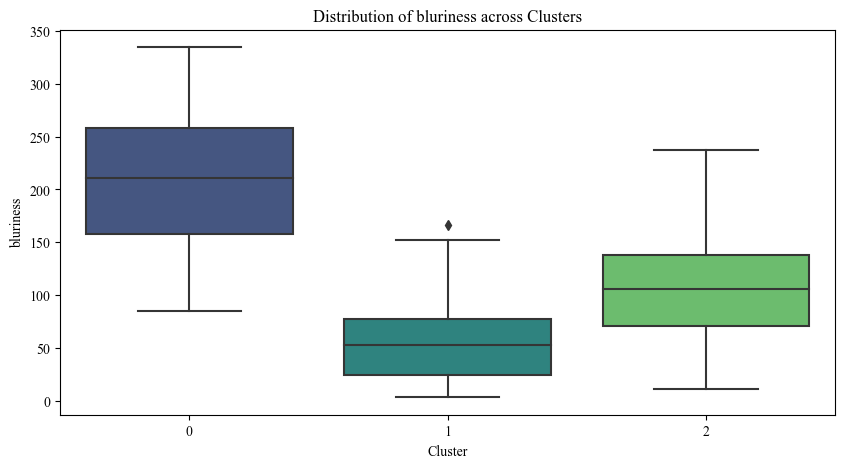

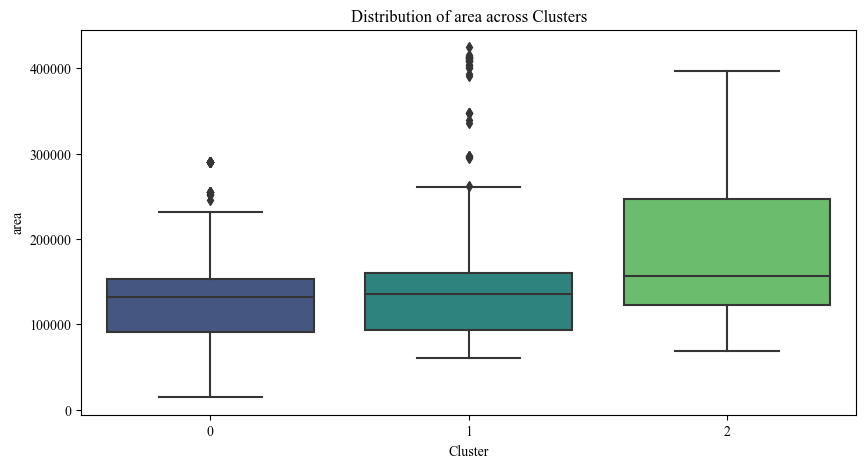

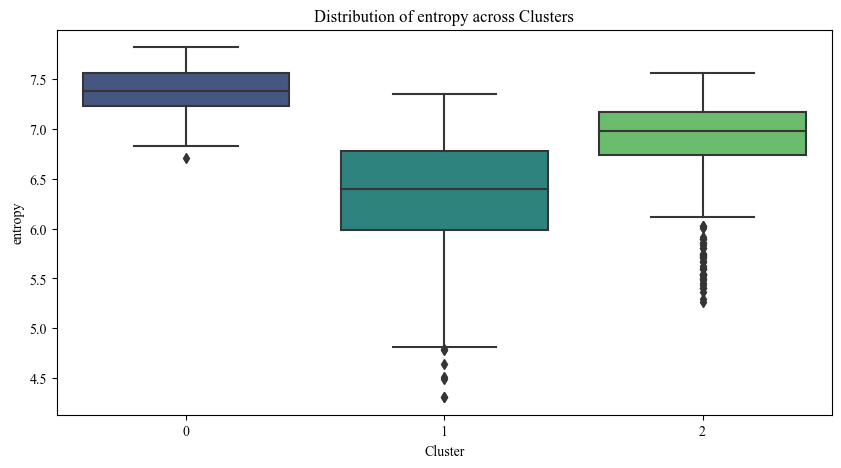

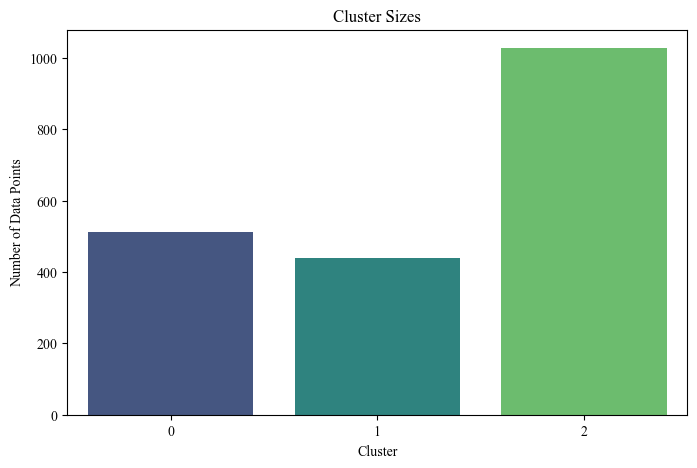

In [80]:
cluster_centers = pipeline.named_steps['kmeans'].cluster_centers_

cluster_centers_df = pd.DataFrame(cluster_centers, columns=numeric_features)

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_centers_df.T, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Cluster Centers')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.show()

for feature in numeric_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=cluster_labels, y=df[feature], palette='viridis')
    plt.title(f'Distribution of {feature} across Clusters')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()

cluster_sizes = np.bincount(cluster_labels)
plt.figure(figsize=(8, 5))
sns.barplot(x=np.arange(len(cluster_sizes)), y=cluster_sizes, palette='viridis')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.show()


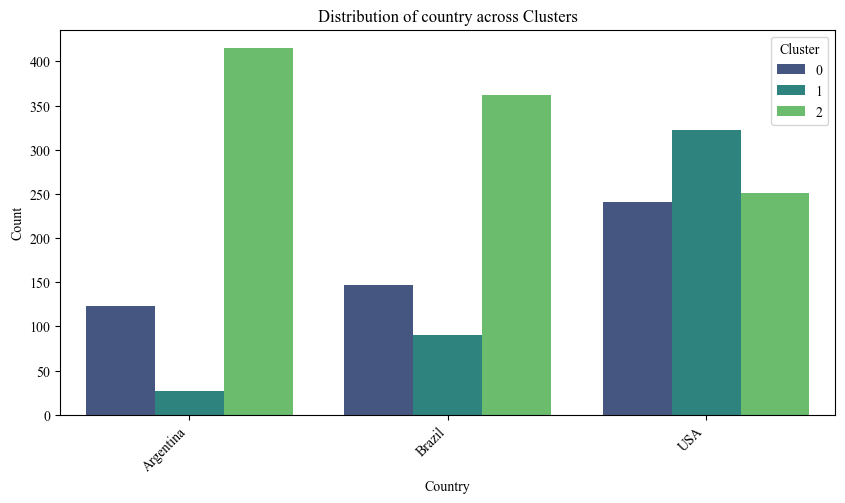

In [81]:
categorical_features = ['country']

for feature in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=feature, hue=cluster_labels, data=df, palette='viridis')
    plt.title(f'Distribution of {feature} across Clusters')
    plt.xlabel('Country')
    plt.ylabel('Count')
    plt.xticks(ticks=np.arange(len(label_encoder.classes_)), labels=label_encoder.classes_, rotation=45, ha='right')
    plt.legend(title='Cluster')
    plt.show()

cluster_labels_str = cluster_labels.astype(str)

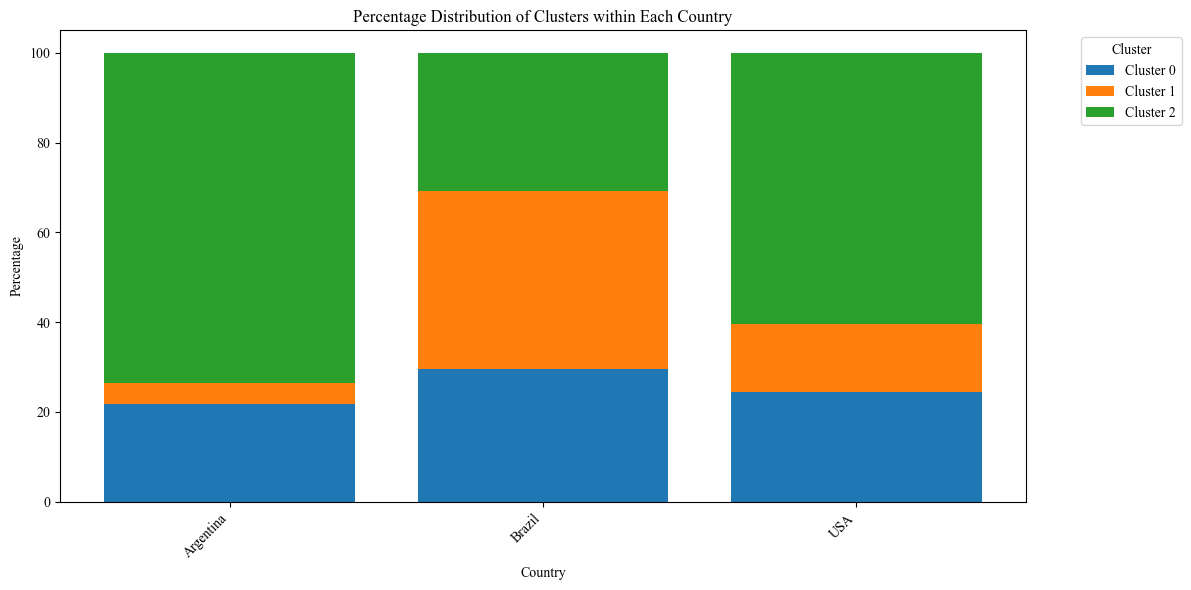

In [82]:
cluster_country_percentage = pd.crosstab(pipeline_df['country'], cluster_labels, normalize='index') * 100

plt.figure(figsize=(12, 6))

bottom = np.zeros(len(cluster_country_percentage.index))

for cluster in cluster_country_percentage.columns:
    percentages = cluster_country_percentage[cluster]
    plt.bar(cluster_country_percentage.index, percentages, bottom=bottom, label=f'Cluster {cluster}')
    bottom += percentages

plt.title('Percentage Distribution of Clusters within Each Country')
plt.xlabel('Country')
plt.ylabel('Percentage')
plt.xticks(ticks=np.arange(len(cluster_country_percentage.index)), labels=label_encoder.inverse_transform(cluster_country_percentage.index), rotation=45, ha='right')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [83]:
groups = {}
for i, label in enumerate(cluster_labels):
    if label not in groups:
        groups[label] = []
    groups[label].append(df.iloc[i]) 

In [84]:
def find_smaller_image(cluster, current_file, start_index=0):
    cluster_files = [file.image_name for file in groups[cluster][start_index:]]
    for file in cluster_files:
        if file != current_file:  
            img = load_img(file)
            img = np.array(img)
            if img.shape[1] <= 400:  
                return file
    return current_file 


def view_cluster(cluster, n=20):
    num_rows = int(np.ceil(n / 5))  
    plt.figure(figsize=(20, 4 * num_rows))  # Ajusta el tamaño de la figura para mostrar más imágenes en una fila
    files = [file.image_name for file in groups[cluster]]
    if len(files) > n:
        print(f"Reduciendo el tamaño del clúster de {len(files)} a {n}")
        files = files[:n]
    for index, file in enumerate(files):
        plt.subplot(num_rows, 5, index + 1) 
        img = load_img(file)
        img = np.array(img)
        if img.shape[1] > 400:  
            new_file = find_smaller_image(cluster, file, index + 1)
            img = load_img(new_file)
            img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()  # Ajusta automáticamente los subgráficos para minimizar la superposición
    plt.show()

Reduciendo el tamaño del clúster de 511 a 20


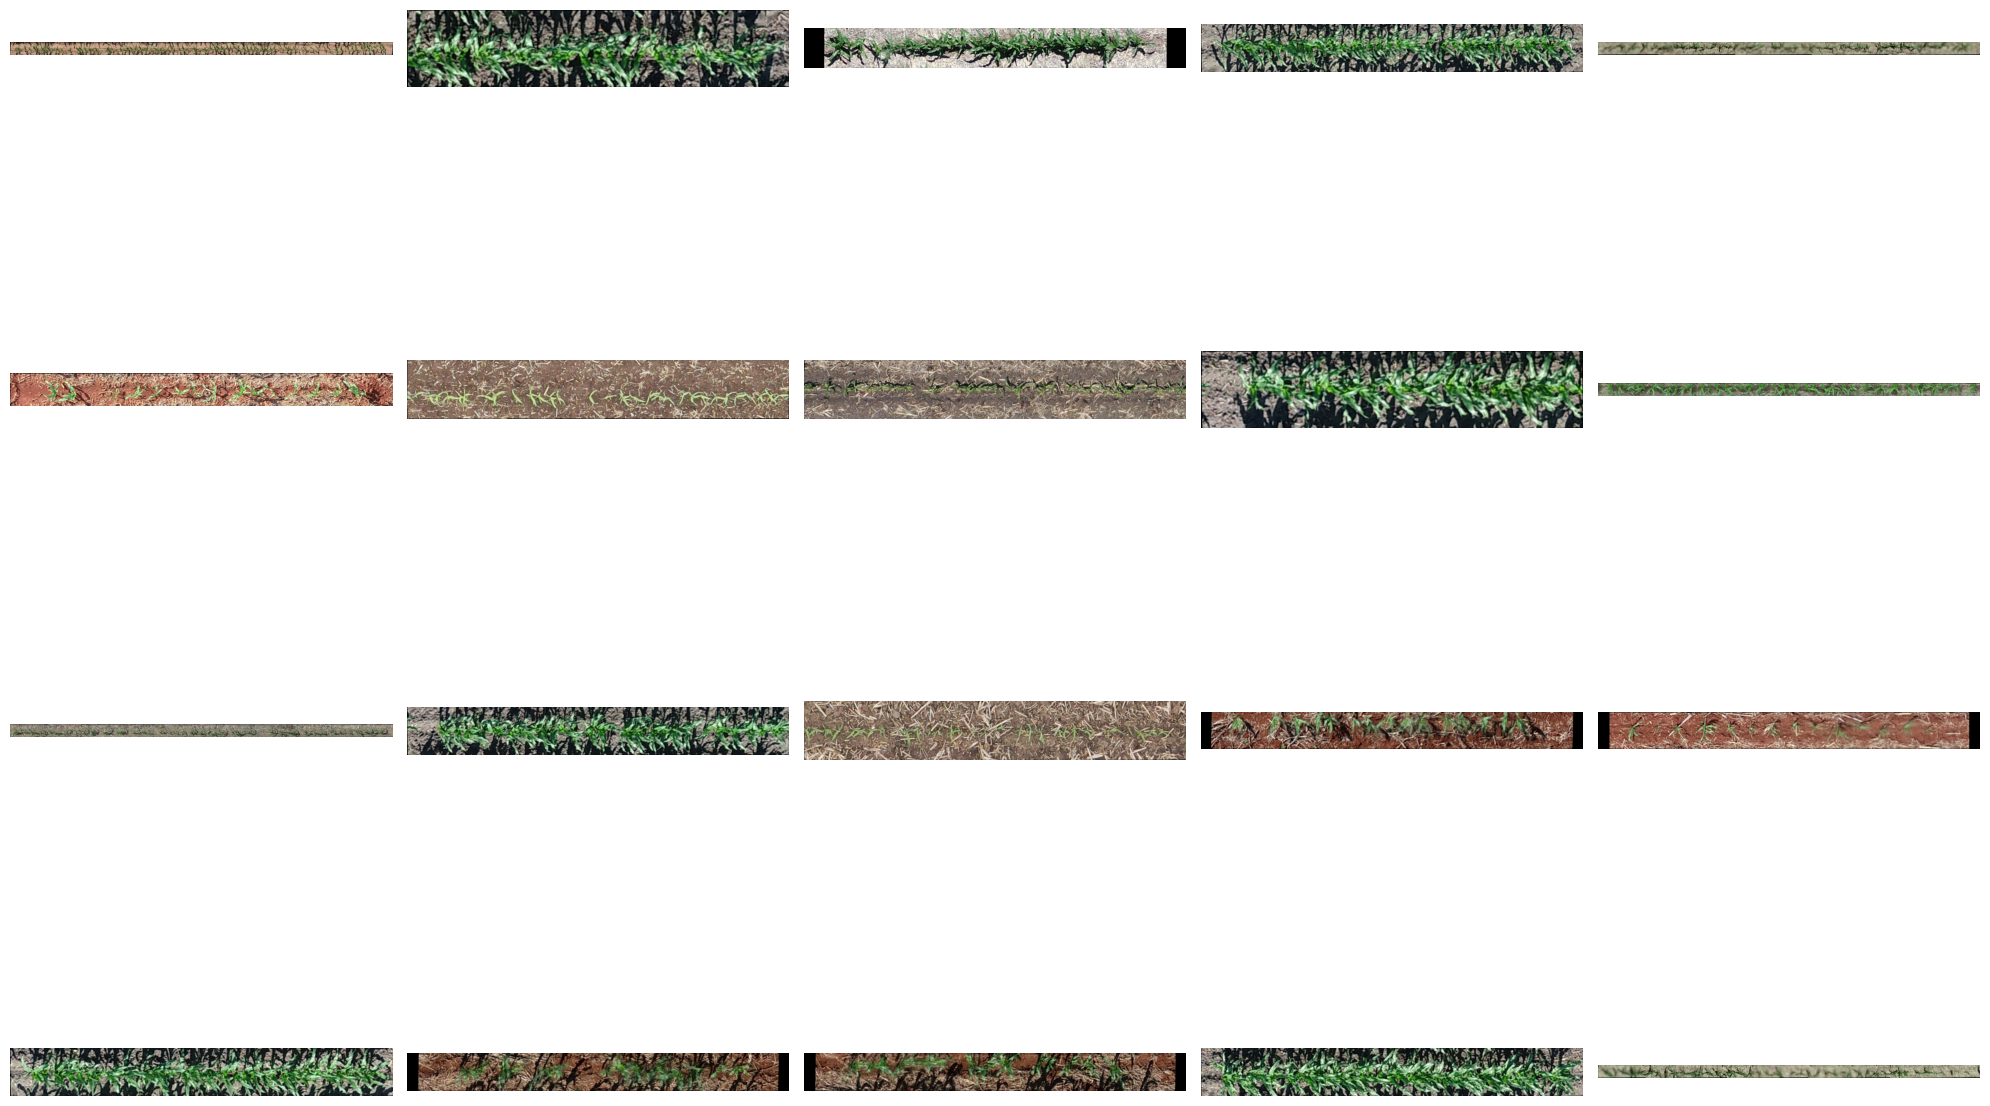

Reduciendo el tamaño del clúster de 439 a 20


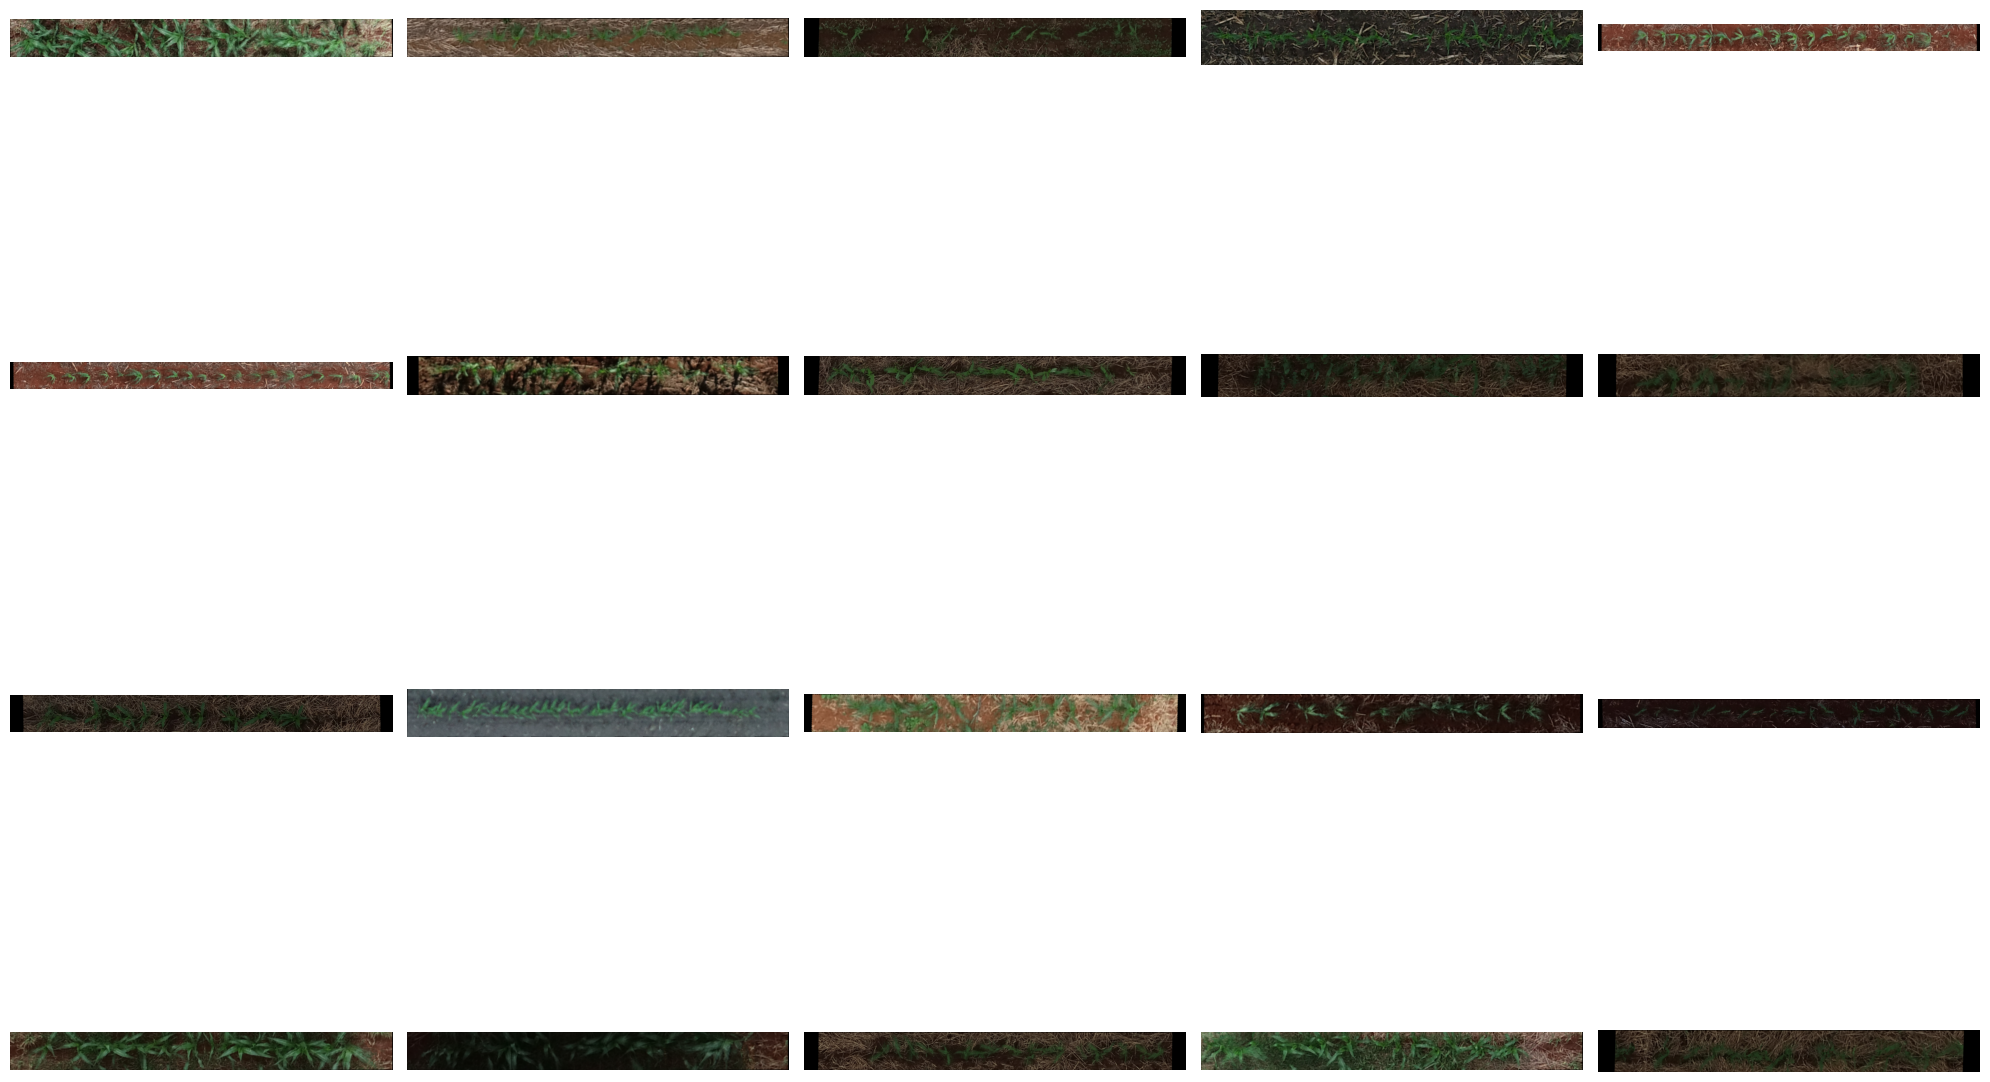

Reduciendo el tamaño del clúster de 1028 a 20


KeyboardInterrupt: 

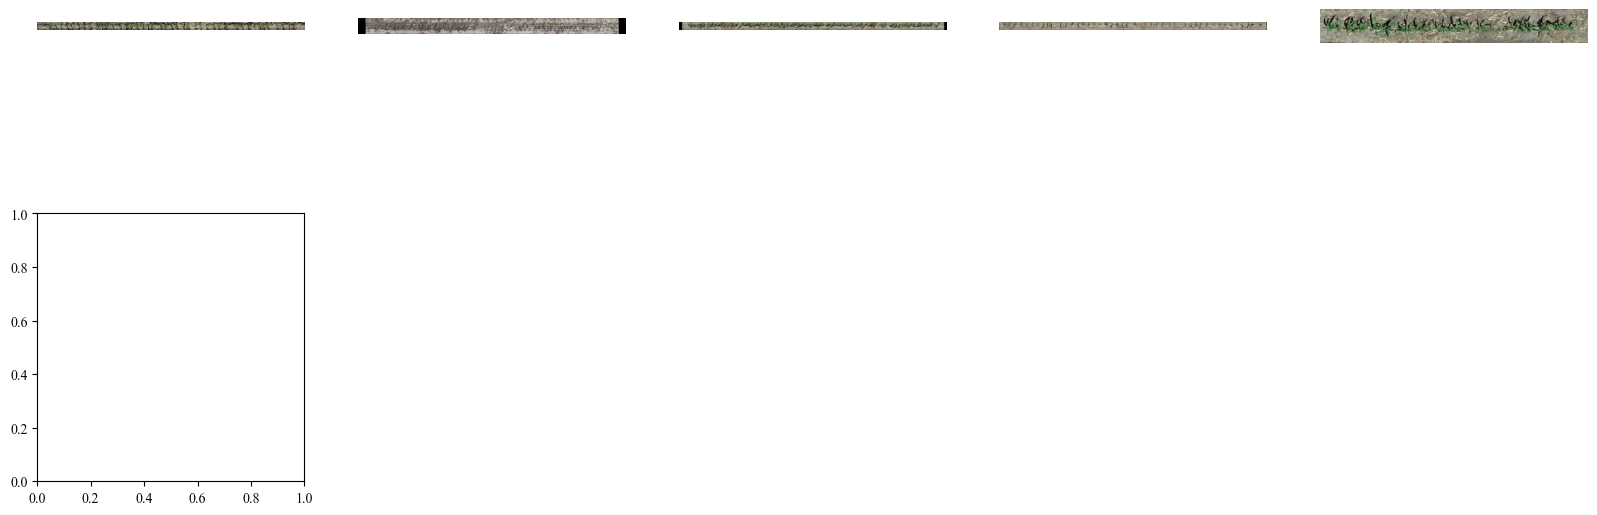

In [85]:
for cluster_label in np.unique(cluster_labels):
    view_cluster(cluster_label)
    plt.show()

# Clustering usando libreria VGG16

In [86]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [87]:
def extract_features(file, model):
    img = load_img(file, target_size=(224,224))
    img = np.array(img) 
    reshaped_img = img.reshape(1,224,224,3) 
    imgx = preprocess_input(reshaped_img)
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [88]:
data = {}
p = r"../02.0-am-clustering.ipynb"

In [89]:
for planta in plantas:
    try:
        feat = extract_features(planta,model)
        data[planta] = feat
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

1/1 [==============================] - 0s 126ms/step


In [90]:
filenames = np.array(list(data.keys()))

feat = np.array(list(data.values()))

feat = feat.reshape(-1,4096)
unique_labels = [os.path.splitext(file)[0] for file in plantas]

In [91]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [92]:
kmeans = KMeans(n_clusters=len(unique_labels), random_state=22)
kmeans.fit(x)

/Users/azulmakk/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=1978, random_state=22)

In [93]:
groups = {}
matplotlib.rcParams['font.family'] = 'Times New Roman'
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [94]:
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

/Users/azulmakk/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/azulmakk/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/azulmakk/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/azulmakk/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

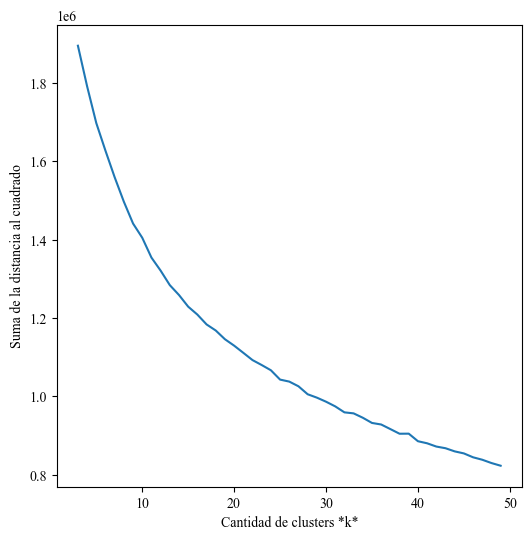

In [95]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Cantidad de clusters *k*')
plt.ylabel('Suma de la distancia al cuadrado');

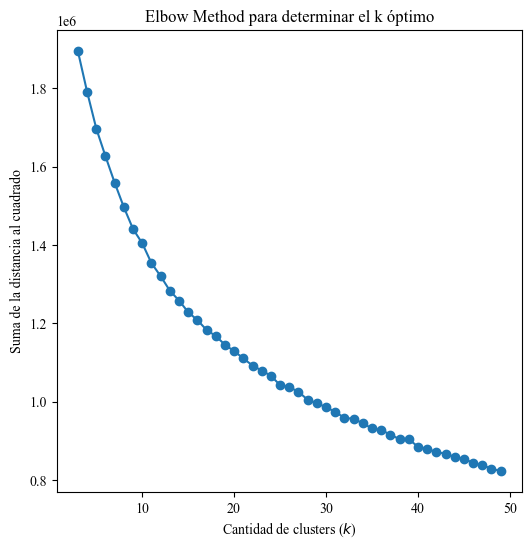

In [96]:
unique_labels_with_clusters = list(zip(unique_labels, kmeans.labels_))

df_clusters = pd.DataFrame(unique_labels_with_clusters, columns=['label', 'cluster'])

df_clusters.to_csv('./labels_clusters.csv', index=False)

sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22, n_init=10)
    km.fit(x)
    
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, marker='o')
plt.xlabel(r'Cantidad de clusters ($k$)')
plt.ylabel('Suma de la distancia al cuadrado')
plt.title('Elbow Method para determinar el k óptimo')
plt.show()

In [97]:
num_clusters = 7 # Cantidad óptima de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=22)
kmeans.fit(x)

df_clusters = pd.DataFrame({'label': unique_labels, 'cluster': kmeans.labels_})
df_clusters.to_csv('/Users/azulmakk/Universidad/Proyecto Final/label_cluster.csv', index=False)

/Users/azulmakk/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


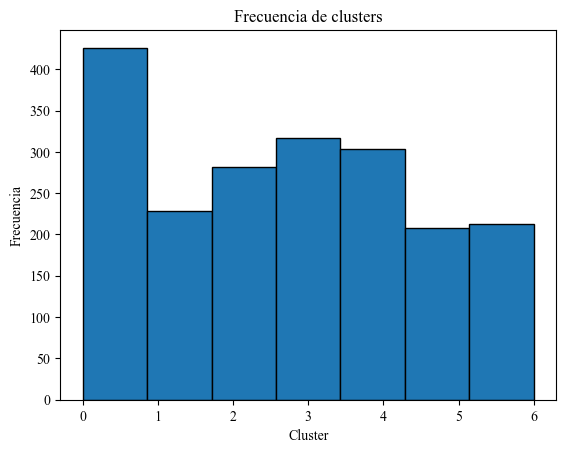

In [98]:
plt.hist(kmeans.labels_, bins=num_clusters, edgecolor='black', align='mid')
plt.xlabel('Cluster')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de clusters')
plt.xticks(range(num_clusters))
plt.show()

In [99]:
groups = {}
for file, cluster in zip(filenames, kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
    groups[cluster].append(file)


# Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(x, kmeans.labels_)
print("Índice de Silueta promedio:", silhouette_avg)

Índice de Silueta promedio: 0.115659334


El valor del índice de silueta varía entre -1 y 1. Un valor cercano a 1 indica que los clústeres están bien separados, mientras que un valor cercano a -1 indica que los clústeres están muy superpuestos. Un valor cercano a 0 indica que hay clústeres superpuestos o que están muy cerca uno del otro.

En este caso, el índice de silueta promedio es 0.115659334. Esto sugiere que los clústeres no están muy bien separados, pero tampoco están demasiado superpuestos. Los clústeres tienen cierto grado de separación, pero todavía hay cierta superposición entre ellos. En general, el valor del índice de silueta promedio indica que la estructura de clústeres en el conjunto de datos no es muy clara, y podría haber margen para mejorar la separación de los clústeres mediante ajustes en el algoritmo de agrupamiento o en los datos de entrada.

# Inercia

/Users/azulmakk/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/azulmakk/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/azulmakk/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/azulmakk/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

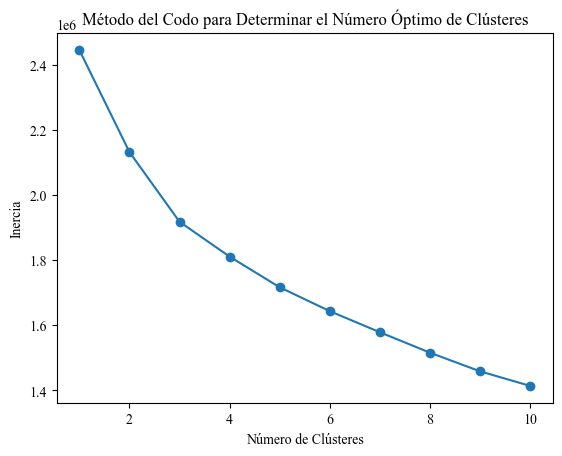

In [ ]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=22)
    kmeans.fit(x)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar el Número Óptimo de Clústeres')
plt.show()

# Centroides

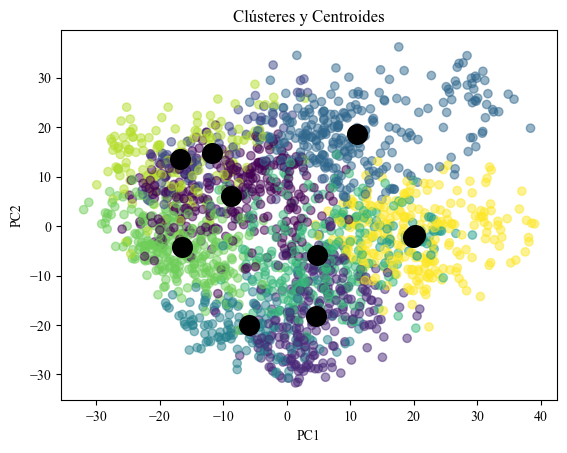

In [ ]:
centroids = kmeans.cluster_centers_

plt.scatter(x[:, 0], x[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', c='black', s=200, edgecolor='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clústeres y Centroides')
plt.show()

In [ ]:
# subcluster_labels = KMeans(n_clusters=7, random_state=42).fit_predict(x[kmeans.labels_ == cluster])
# subcluster_centers = KMeans(n_clusters=7, random_state=42).fit(x[kmeans.labels_ == cluster]).cluster_centers_

# plt.scatter(x[kmeans.labels_ == cluster, 0], x[kmeans.labels_ == cluster, 1], c=subcluster_labels, cmap='viridis', alpha=0.5)
# plt.scatter(subcluster_centers[:, 0], subcluster_centers[:, 1], marker='o', c='black', s=200, edgecolor='k')
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.title('Subgrupos dentro del Clúster')
# plt.show()

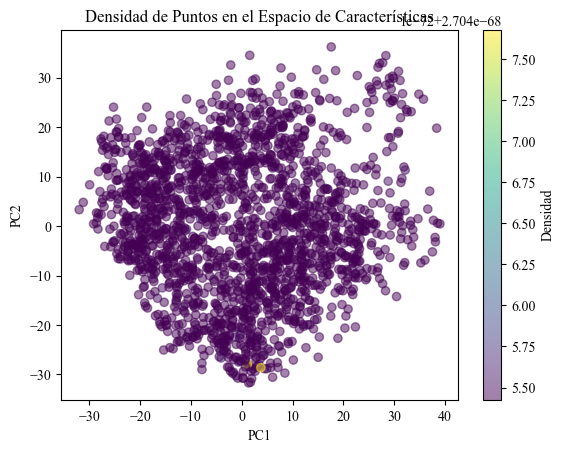

In [ ]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(x.T)
density = kde(x.T)

plt.scatter(x[:, 0], x[:, 1], c=density, cmap='viridis', alpha=0.5)
plt.colorbar(label='Densidad')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Densidad de Puntos en el Espacio de Características')
plt.show()